In [1]:
import pandas as pd

# file name SolarPrediction.csv
file_path = r"C:\Users\86133\LSTM\archive\SolarPrediction.csv"
df = pd.read_csv(file_path)


print(df.head())

     UNIXTime                   Data      Time  Radiation  Temperature  \
0  1475229326  9/29/2016 12:00:00 AM  23:55:26       1.21           48   
1  1475229023  9/29/2016 12:00:00 AM  23:50:23       1.21           48   
2  1475228726  9/29/2016 12:00:00 AM  23:45:26       1.23           48   
3  1475228421  9/29/2016 12:00:00 AM  23:40:21       1.21           48   
4  1475228124  9/29/2016 12:00:00 AM  23:35:24       1.17           48   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        59                  177.39   5.62    06:13:00   18:13:00  
1     30.46        58                  176.78   3.37    06:13:00   18:13:00  
2     30.46        57                  158.75   3.37    06:13:00   18:13:00  
3     30.46        60                  137.71   3.37    06:13:00   18:13:00  
4     30.46        62                  104.95   5.62    06:13:00   18:13:00  


In [2]:
# transfer timestap to datetime
df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])
df = df.sort_values(by='Timestamp') 

C:\Users\86133\AppData\Local\Temp\ipykernel_18028\3219091102.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])


In [3]:
# feature pre-processing
df['SunriseMinutes'] = pd.to_timedelta(df['TimeSunRise']).dt.total_seconds() / 60
df['SunsetMinutes'] = pd.to_timedelta(df['TimeSunSet']).dt.total_seconds() / 60
df = df.drop(columns=['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet', 'Timestamp'])

In [4]:
# select features and target
features = ['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
target = 'Radiation'

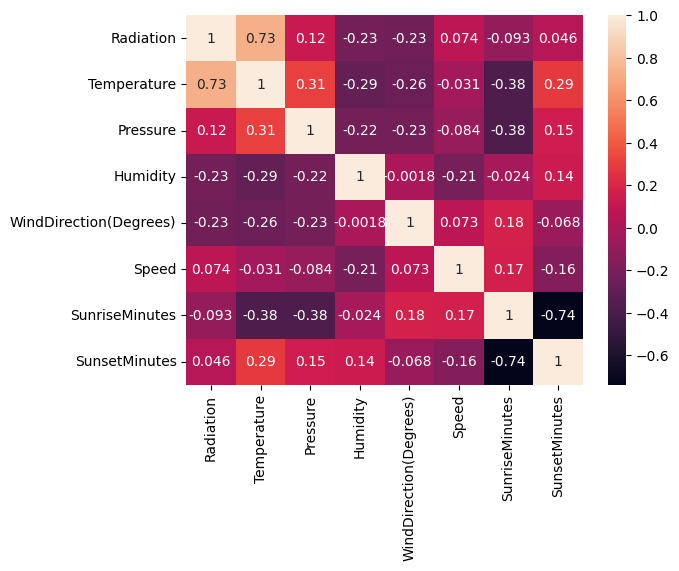

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.heatmap(df.corr(), annot=True);
#using seaborn to generate heatmap

In [6]:
# data normalization
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features + [target]])

# time series formatting
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, :-1])  
        y.append(data[i + time_step, -1])    
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

In [7]:
# data train-split and validation
train_size = int(len(X) * 0.7)  # 70% for training
val_size = int(len(X) * 0.15)   # 15% for validation
test_size = len(X) - train_size - val_size  # 15% for testing

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (22873, 10, 5)
Validation data size: (4901, 10, 5)
Testing data size: (4902, 10, 5)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Reshape, LSTM, Lambda
from tensorflow.keras.layers import Dropout

# data remodeling：Conv2D
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# construct model
model = Sequential()

# Conv2D layer：used to extract feature
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)))
model.add(BatchNormalization())  # normalization
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten()) 

# add Dropout layer
model.add(Dropout(0.3))  

# reshape the LSTM in order to meet the input requirement
model.add(Reshape((-1, 64)))  

# LSTM layer
model.add(LSTM(units=50, return_sequences=True))

# define MultiHeadAttention layer
query = model.output
value = model.output
key = model.output

# Multi-Head Attention layer
attention_output = MultiHeadAttention(num_heads=2, key_dim=50)(query, key, value)

#  out put Attention layer to  LSTM for processing
model.add(Reshape((-1, 50)))  
model.add(LSTM(units=50, return_sequences=False))


model.add(Dropout(0.3)) 

# output layer(regression)
model.add(Dense(units=1))  # output predicted data

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [22]:

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1, callbacks=[early_stopping])


Epoch 1/100
715/715 [==============================] - 9s 10ms/step - loss: 0.0184 - mae: 0.0947 - val_loss: 0.0159 - val_mae: 0.0863
Epoch 2/100
715/715 [==============================] - 6s 9ms/step - loss: 0.0133 - mae: 0.0757 - val_loss: 0.0145 - val_mae: 0.0890
Epoch 3/100
715/715 [==============================] - 6s 9ms/step - loss: 0.0116 - mae: 0.0684 - val_loss: 0.0137 - val_mae: 0.0620
Epoch 4/100
715/715 [==============================] - 6s 9ms/step - loss: 0.0109 - mae: 0.0651 - val_loss: 0.0160 - val_mae: 0.0992
Epoch 5/100
715/715 [==============================] - 6s 9ms/step - loss: 0.0100 - mae: 0.0620 - val_loss: 0.0181 - val_mae: 0.0895
Epoch 6/100
715/715 [==============================] - 6s 9ms/step - loss: 0.0097 - mae: 0.0601 - val_loss: 0.0155 - val_mae: 0.0793
Epoch 7/100
715/715 [==============================] - 6s 9ms/step - loss: 0.0093 - mae: 0.0587 - val_loss: 0.0107 - val_mae: 0.0577
Epoch 8/100
715/715 [==============================] - 6s 9ms/step -

In [23]:
import matplotlib.pyplot as plt

# extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# extract train and validation mae
train_mae = history.history['mae']
val_mae = history.history['val_mae']

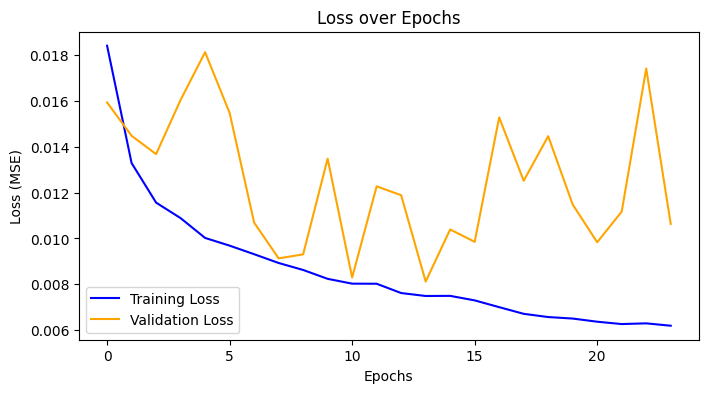

In [24]:
# generate loss figure
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

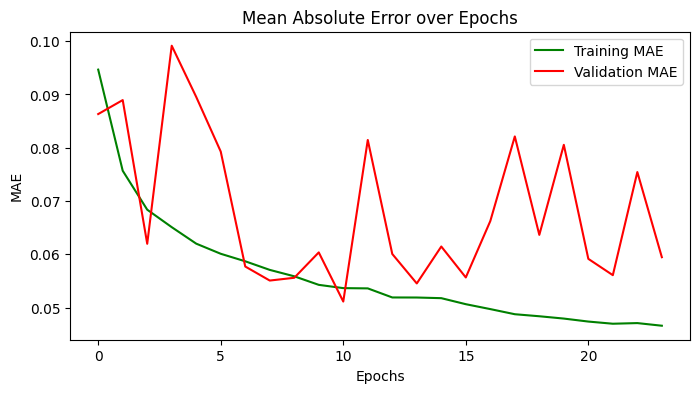

In [25]:
# generate mae figure
plt.figure(figsize=(8, 4))  
plt.plot(train_mae, label='Training MAE', color='green')
plt.plot(val_mae, label='Validation MAE', color='red')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

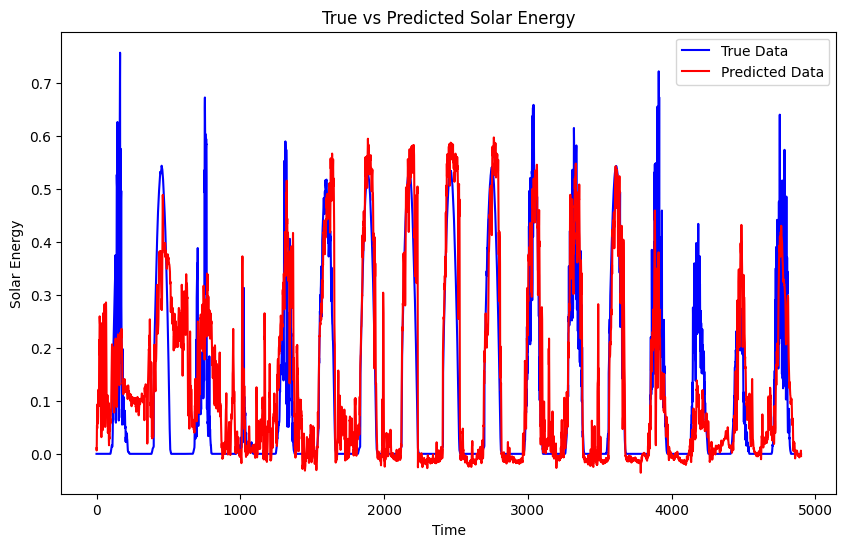

In [28]:
import matplotlib.pyplot as plt

# prediction
y_pred = model.predict(X_test_reshaped)

# compare predicted data and true data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red')
plt.title('True vs Predicted Solar Energy')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.show()


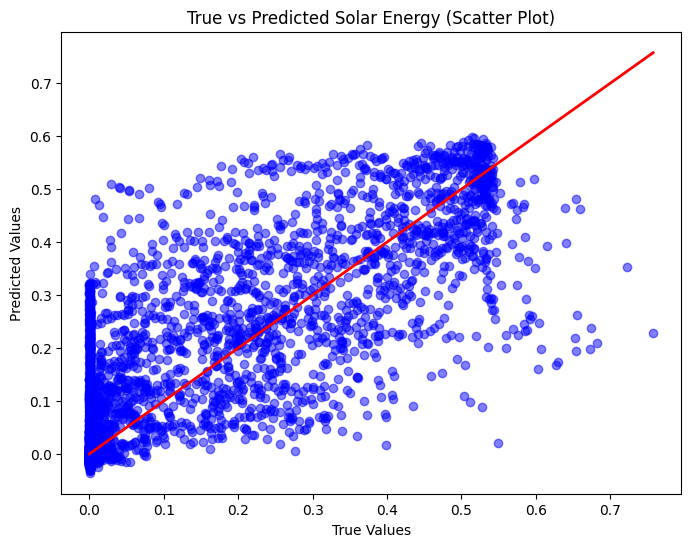

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  
plt.title('True vs Predicted Solar Energy (Scatter Plot)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


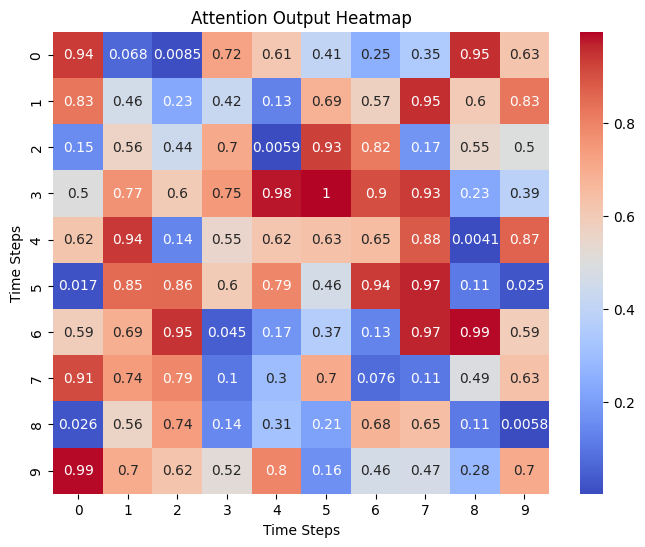

In [30]:
import seaborn as sns
import numpy as np


attention_matrix = np.random.rand(10, 10)  

plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Attention Output Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Time Steps')
plt.show()


In [31]:
from sklearn.metrics import r2_score

# prediction
y_pred = model.predict(X_test_reshaped)

# calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


R² Score: 0.6021334727793768


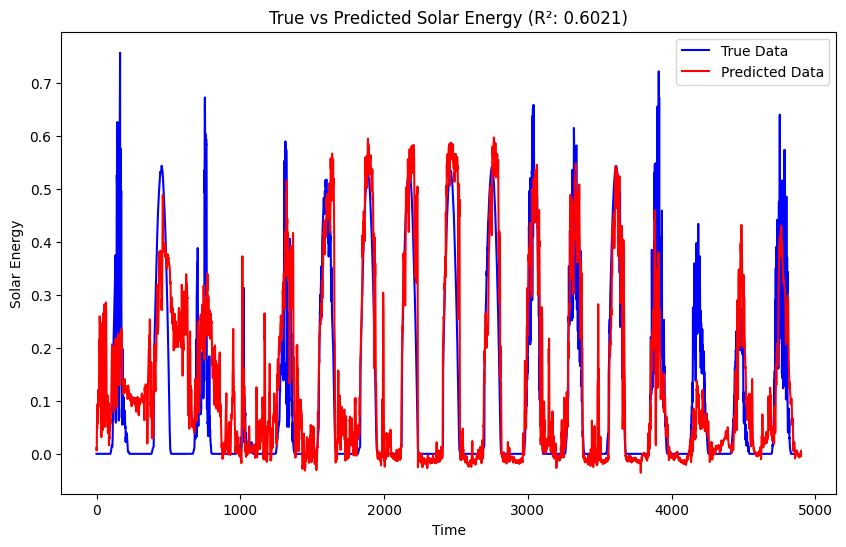

In [32]:
import matplotlib.pyplot as plt

# generate figure for comparation between true and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red')
plt.title(f'True vs Predicted Solar Energy (R²: {r2:.4f})')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.show()


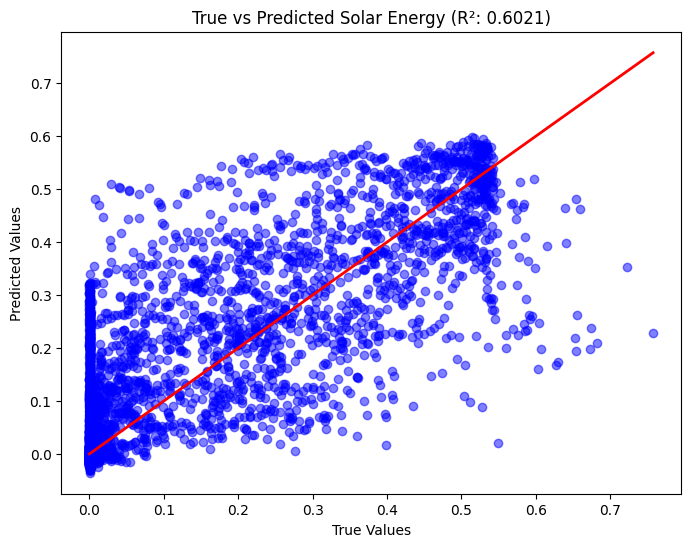

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  
plt.title(f'True vs Predicted Solar Energy (R²: {r2:.4f})')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


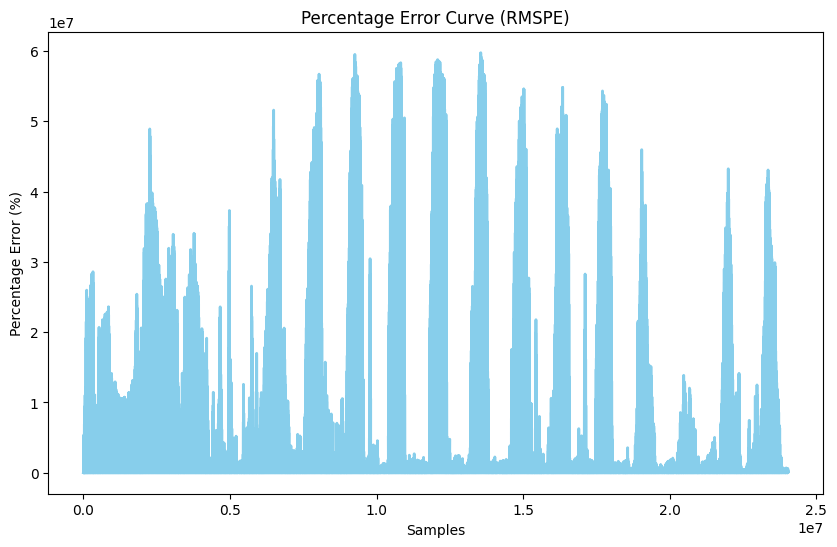

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# calculate percentage errors
percentage_errors = np.abs((y_test - y_pred) / (y_test + 1e-6)) * 100

# flatten percentage_errors 
percentage_errors = percentage_errors.flatten()

# generate percentage errors curve
plt.figure(figsize=(10, 6))
plt.plot(percentage_errors, color='skyblue', linewidth=2)  
plt.title('Percentage Error Curve (RMSPE)')
plt.xlabel('Samples')
plt.ylabel('Percentage Error (%)')
plt.show()


In [45]:
!pip install lime --index-url https://pypi.org/simple

import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer


X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)  

# choose one sample to explain
i = 10  
X_sample = X_train_reshaped[i:i+1]  # get the sample of i

# create LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.reshape(X_train.shape[0], -1), training_labels=y_train, mode='regression', feature_names=[f'feature_{i}' for i in range(X_train.shape[1] * X_train.shape[2])])


def predict_fn_adapter(data):
    data_reshaped = data.reshape(data.shape[0], X_train.shape[1], X_train.shape[2], 1)
    return model.predict(data_reshaped)

# choose one sample to explain
explanation = explainer.explain_instance(X_sample.flatten(), predict_fn_adapter)

# show explain result
explanation.show_in_notebook()



Explained Variance Score (EVS): 0.6314


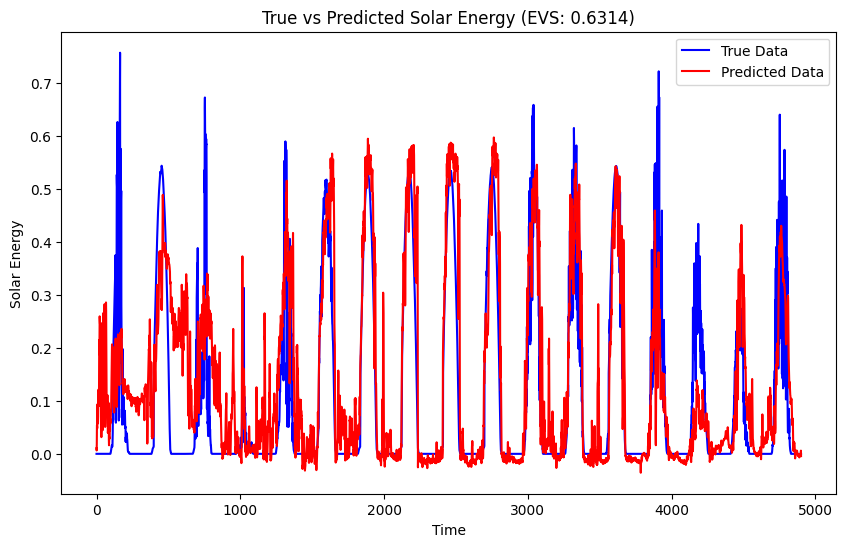

In [49]:
from sklearn.metrics import explained_variance_score

# calculate EVS score
evs = explained_variance_score(y_test, y_pred)

# print EVS score
print(f'Explained Variance Score (EVS): {evs:.4f}')


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red')
plt.title(f'True vs Predicted Solar Energy (EVS: {evs:.4f})')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.show()


Explained Variance Score (EVS): 0.6314


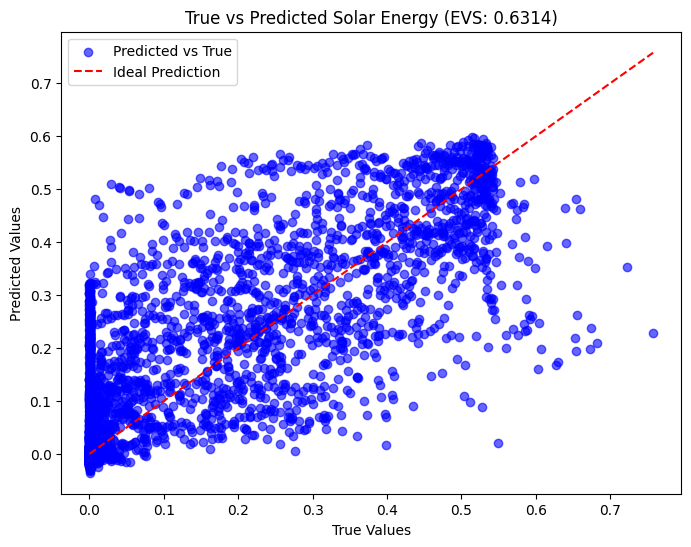

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

# calculate EVS
evs = explained_variance_score(y_test, y_pred)

# print EVS score
print(f'Explained Variance Score (EVS): {evs:.4f}')


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True vs Predicted Solar Energy (EVS: {evs:.4f})')
plt.legend()
plt.show()
